# Assignment #1: Write up a report on U.N. World Happiness Data.

**Davide Vaccari**

# Objective: Predict World Happiness Rankings 

What makes the citizens of one country more happy than the citizens of other countries?  Do variables measuring perceptions of corruption, GDP, maintaining a healthy lifestyle, or social support associate with a country's happiness ranking?  

Let's use the United Nation's World Happiness Rankings country level data to experiment with models that predict happiness rankings well.


---

**Data**: 2019 World Happiness Survey Rankings
*(Data can be found on Advanced Projects in ML courseworks site)*

**Features**
*   Country or region
*   GDP per capita
*   Social support
*   Healthy life expectancy
*   Freedom to make life choices
*   Generosity
*   Perceptions of corruption

**Target**
*   Happiness_level (Very High = Top 20% and Very Low = Bottom 20%)

Source: https://worldhappiness.report/




To these, I've added:

* Air quality (from https://www.stateofglobalair.org/data/#/air/plot. Hong Kong and Kosovo are the only two countries for which data is missing. For those, I've imputed the mean of the neighboring countries. Macedonia, Albania, Serbia, Montenegro, for Kosovo; China for Hong Kong.)

* Economic inequality (from https://data.worldbank.org/indicator/SI.POV.GINI. Unfortunately, for a lot of the countries in the list, this data is unavailable.)

* Population density (after having seen the impact of air quality, I thought pop density might play a role. Data is from https://data.worldbank.org/indicator/EN.POP.DNST. Most recent data is from 2018.)

* Suicide rates (from https://apps.who.int/gho/data/node.main.MHSUICIDE?lang=en. Data is from 2016.)



## The report should include:

* Explore bivariate results (Use visualizations!)
    - Describe any relationships you see between particular features and the target variable

* Examine features that predict happiness categories using one or more models that allow for automatic feature selection
    - Explain any meaningful findings

* Run at least three prediction models to try to predict World Happiness well.
    - Discuss which models performed better and point out relevant hyper-parameter values for successful models.
    - Submit your best model to the leader board for the World Happiness AI Model Share competition.
      - You have the option to present and/or discuss these models in your report, but it is not required.

# Import the data




In [1]:
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

data=pd.read_csv("final.csv", decimal=',')

data.head()

,Happiness_level,Happiness_level_code,Country,GDP.per.capita,Social.support,Healthy.life.expectancy,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,name,region,sub.region,Mean_Exposure_pm25,Gini_2017,Density,Suicide.rates.2016.
0,Very High,4,Finland,1.340,1.587,0.986,0.596,0.153,0.393,Finland,Europe,Northern Europe,5.57,27.4,18.148547,15.9
1,Very High,4,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,Denmark,Europe,Northern Europe,9.79,28.7,137.976566,12.8
2,Very High,4,Norway,1.488,1.582,1.028,0.603,0.271,0.341,Norway,Europe,Northern Europe,6.64,27.0,14.548292,12.2
3,Very High,4,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,Iceland,Europe,Northern Europe,5.70,NaN,3.518414,14.0
4,Very High,4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,12.00,28.5,511.475928,12.6


In [4]:
data.shape

(156, 16)

In [5]:
data.Gini_2017.isna().sum()

77

Of 156 countries, only 79 (156-77) have Gini Values. Therefore, I will create two datasets. One with all countries and all features but gini, and one with all features but not the countries that do not have gini values.

In [6]:
d1 = data.drop(['name', 'Country', 'sub.region', 'region', 'Gini_2017'], axis=1)
d1.head()

,Happiness_level,Happiness_level_code,GDP.per.capita,Social.support,Healthy.life.expectancy,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Mean_Exposure_pm25,Density,Suicide.rates.2016.
0,Very High,4,1.340,1.587,0.986,0.596,0.153,0.393,5.57,18.148547,15.9
1,Very High,4,1.383,1.573,0.996,0.592,0.252,0.410,9.79,137.976566,12.8
2,Very High,4,1.488,1.582,1.028,0.603,0.271,0.341,6.64,14.548292,12.2
3,Very High,4,1.380,1.624,1.026,0.591,0.354,0.118,5.70,3.518414,14.0
4,Very High,4,1.396,1.522,0.999,0.557,0.322,0.298,12.00,511.475928,12.6


In [7]:
d1.dtypes

Happiness_level                  object
Happiness_level_code              int64
GDP.per.capita                  float64
Social.support                  float64
Healthy.life.expectancy         float64
Freedom.to.make.life.choices    float64
Generosity                      float64
Perceptions.of.corruption       float64
Mean_Exposure_pm25              float64
Density                         float64
Suicide.rates.2016.             float64
dtype: object

In [8]:
d2 = data[data['Gini_2017'].notna()]
d2 = d2.drop(['name', 'Country', 'sub.region', 'region'], axis=1)
d2.head()

,Happiness_level,Happiness_level_code,GDP.per.capita,Social.support,Healthy.life.expectancy,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Mean_Exposure_pm25,Gini_2017,Density,Suicide.rates.2016.
0,Very High,4,1.340,1.587,0.986,0.596,0.153,0.393,5.57,27.4,18.148547,15.9
1,Very High,4,1.383,1.573,0.996,0.592,0.252,0.410,9.79,28.7,137.976566,12.8
2,Very High,4,1.488,1.582,1.028,0.603,0.271,0.341,6.64,27.0,14.548292,12.2
4,Very High,4,1.396,1.522,0.999,0.557,0.322,0.298,12.00,28.5,511.475928,12.6
5,Very High,4,1.452,1.526,1.052,0.572,0.263,0.343,9.90,32.7,215.465350,17.2


___
# Exploring bivariate results using visualizations
## Describe any relationships you see between particular features and the target variable
  

In [9]:
corr_matrix = data.corr()
print(corr_matrix["Happiness_level_code"].sort_values(ascending=False))

Happiness_level_code            1.000000
GDP.per.capita                  0.789635
Healthy.life.expectancy         0.786932
Social.support                  0.738577
Freedom.to.make.life.choices    0.525097
Perceptions.of.corruption       0.323730
Suicide.rates.2016.             0.259790
Density                         0.069617
Generosity                      0.028123
Gini_2017                      -0.177315
Mean_Exposure_pm25             -0.469938
Name: Happiness_level_code, dtype: float64


The strongest correlations of happiness are with GDP/capita, Healthy life expectancy, and social support.

### GDP/capita

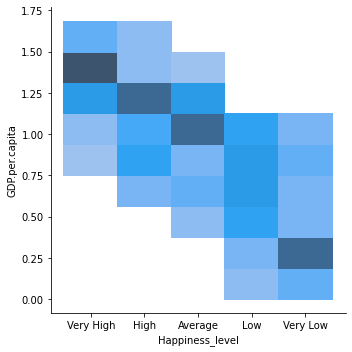

In [10]:
sns.displot(d1, x="Happiness_level", y="GDP.per.capita")

### Healthy life expectancy

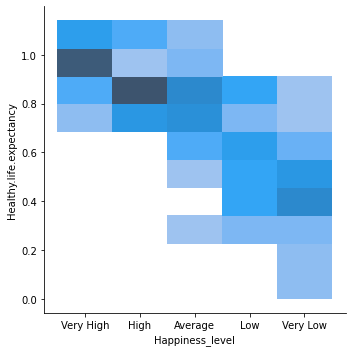

In [11]:
sns.displot(d1, x="Happiness_level", y="Healthy.life.expectancy")

### Social Support

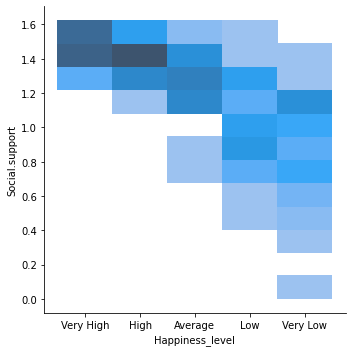

In [12]:
sns.displot(d1, x="Happiness_level", y="Social.support")

### Mean exposure to pm2.5 pollutant

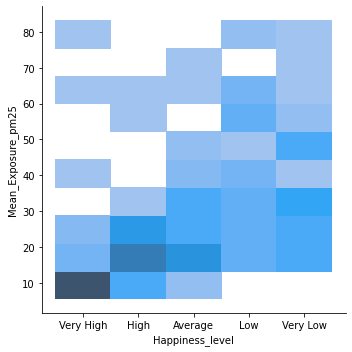

In [13]:
sns.displot(d1, x="Happiness_level", y="Mean_Exposure_pm25")

There seems to be a clear relationship that the lower the exposure to air pollutants (pm 2.5) the higher the happiness level. It's interesting, I expected the opposite.

### Generosity

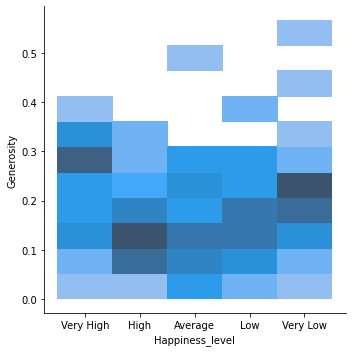

In [14]:
sns.displot(d1, x="Happiness_level", y="Generosity")

Generosity levels seem sparse. It doesn't look like that there is an higher correlation with happiness.

### Suicide rates

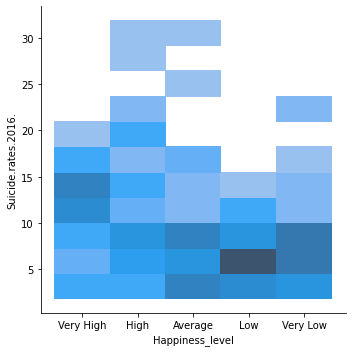

In [15]:
sns.displot(d1, x="Happiness_level", y="Suicide.rates.2016.")

Suicide levels too do not have a strong correlation.

### Gini Index

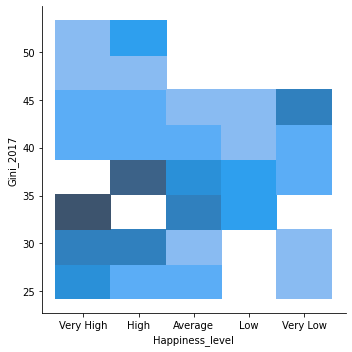

In [16]:
sns.displot(data=d2, x="Happiness_level", y="Gini_2017")

It seems that countries with higher happiness levels have lower gini(s) than countries with lower happiness levels. However, it's not a strong correlation.

### Population density

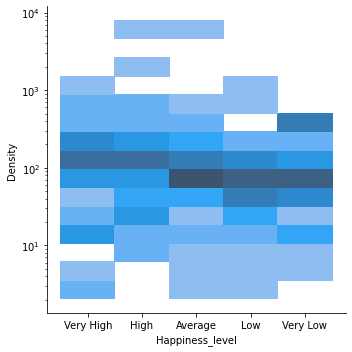

In [17]:
sns.displot(d1, x="Happiness_level", y="Density", log_scale=(False, True))

Population density, as generosity, almost doesn't have any correlation at all with happiness.

**Note**: Gini Index has an interesting correlation level. However, I won't be exploring it further in this report as the data is available for just 2/3 of the dataset, which is already small.

___
# Feature setup and preprocessor building

In [18]:
# Clean up final region data
X = d1.drop(['Happiness_level', 'Happiness_level_code'], axis=1)
y = d1['Happiness_level_code']

X.shape, y.shape

((156, 9), (156,))

In [19]:
# Set up training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_train.columns.tolist())

(117, 9)
(117,)
['GDP.per.capita', 'Social.support', 'Healthy.life.expectancy', 'Freedom.to.make.life.choices', 'Generosity', 'Perceptions.of.corruption', 'Mean_Exposure_pm25', 'Density', 'Suicide.rates.2016.']


## Preprocess data using Column Transformer

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features=X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])


#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 



In [21]:
# Write function to transform data with preprocessor

def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [22]:
# Check shape for keras input:
preprocessor(X_train).shape

(117, 9)

In [23]:
# Check shape for keras output:
pd.get_dummies(y_train).shape

(117, 5)

___
# Feature Selection

To automatically select features I use l1 "Lasso" logistic regression, and Random Forest.

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear"), max_features=9)
embeded_lr_selector.fit(preprocessor(X_train), y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

9 selected features


Lasso logistic regression doesn't remove any of the features.

In [25]:
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=9)
embeded_rf_selector.fit(preprocessor(X_train), y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

4 selected features


In [26]:
print(str(embeded_rf_feature))

['GDP.per.capita', 'Social.support', 'Healthy.life.expectancy', 'Freedom.to.make.life.choices']


On the other hand, Random Forest cuts down the number of features to the three the showed the highest correlation with the target variable.

**Let's take a look to how these two models perform**

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skfold = StratifiedKFold(n_splits=5, shuffle=True) 

In [28]:
logreg = LogisticRegression(penalty = 'l1', solver='liblinear').fit(preprocessor(X_train), y_train)

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(logreg, preprocessor(X_train), y_train, cv=skfold))))
print("Penalyzed Lasso logistic regression Test-Data prediction accuracy: {:.5f}".format(logreg.score(preprocessor(X_test), y_test)))

# Model coefficients
logreg_coef = pd.DataFrame(data=logreg.coef_, columns=X.columns)
logreg_coef.head()

Mean Cross Validation, SKFold: 0.56
Penalyzed Lasso logistic regression Test-Data prediction accuracy: 0.35897


,GDP.per.capita,Social.support,Healthy.life.expectancy,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Mean_Exposure_pm25,Density,Suicide.rates.2016.
0,-0.858568,-0.417073,-0.999354,-0.779809,0.500597,0.109445,-0.449097,0.000000,0.223494
1,-0.459604,0.000000,-0.177840,0.215010,-0.493281,-0.063945,0.376502,0.000000,-0.801483
2,0.132737,0.008181,0.512527,-0.195886,0.000000,-0.837678,0.000000,0.241693,-0.137686
3,0.000000,1.004701,0.479529,0.663403,-0.489890,-1.048154,0.000000,0.441998,0.361041
4,1.201290,0.654272,0.628078,0.543106,0.164953,1.032501,0.000000,-0.845359,-0.398668


Logistic Regression is normally used with binomial target variables. When it's multiclass, like in this case, the training algorithm uses the one-vs-rest (OvR) scheme, since the solver is 'liblinear'. We can see that Lasso brought some features to 0 for some labels, but no feature has been brought to zero for any label.

In [29]:
RFC=RandomForestClassifier(n_estimators=1000, random_state = 0)

RFC.fit(preprocessor(X_train), y_train)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Random Forest Classifier's cross validation accuracy:", np.mean(cross_val_score(RFC, preprocessor(X_train), y_train, cv=skfold)))
print("Random Forest Classifier's Test-Data prediction accuracy: {:.5f}".format(RFC.score(preprocessor(X_test), y_test)))

Random Forest Classifier's cross validation accuracy: 0.5297101449275362
Random Forest Classifier's Test-Data prediction accuracy: 0.41026


Random Forest performs significantly better.

### Bonus: let's see if the explanation gave by these features can be captured by Principal Component Analysis.

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA()
principalComponents = pca.fit_transform(preprocessor(X))

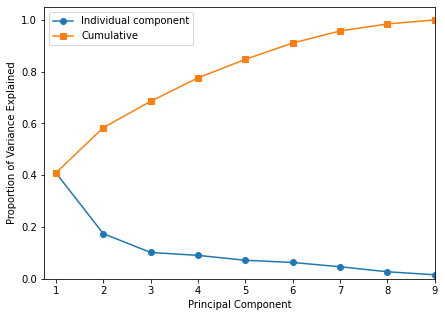

In [32]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4,5,6,7,8,9], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4,5,6,7,8,9], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9])
plt.legend(loc=2);

It seems like the first three to four PCs are the ones explaining more. However, since the dataset is small, I'll continue the analysis with all the features and all the components.

___
# Three prediction models to predict World Happiness.

In [33]:
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

## Model 1: "Ridge" l2 penalized logistic regression
While using the "Lasso" l1, I've noticed that "Ridge" l2 performed significantly better.

In [34]:
mod1 = LogisticRegression(penalty = 'l2').fit(preprocessor(X_train), y_train)

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(mod1, preprocessor(X_train), y_train, cv=skfold))))
print("Penalyzed Lasso logistic regression Test-Data prediction accuracy: {:.5f}".format(mod1.score(preprocessor(X_test), y_test)))

Mean Cross Validation, SKFold: 0.50
Penalyzed Lasso logistic regression Test-Data prediction accuracy: 0.51282


In [35]:
hyperparameters = {'C':np.logspace(1, 10, 100), 'penalty':['l2']}

logit = LogisticRegression(max_iter=10000)
logit_cv = GridSearchCV(logit, hyperparameters, cv = skfold)
logit_cv.fit(preprocessor(X_train), y_train)

print("Best Parameters {:.3f}: ", logit_cv.best_params_)

Best Parameters {:.3f}:  {'C': 10.0, 'penalty': 'l2'}


In [36]:
mod1 = LogisticRegression(C=53.37, penalty='l2')

mod1.fit(preprocessor(X_train), y_train)

mod1.score(preprocessor(X_train), y_train)

0.717948717948718

In [37]:
y_pred = mod1.predict(preprocessor(X_test))

In [38]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 53.85%


Tuning the hyperparameters, Accuracy on test improved of about 2%.

___
## Model 2: Neural Network in Keras

In [39]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD, Adam, Adagrad

Using TensorFlow backend.


In [40]:
# Function to create model, required for KerasClassifier
def create_model(hn2=1, hn3=1):
  model = Sequential()
  model.add(Dense(128, input_dim = 9, activation = 'relu'))
  model.add(Dense(hn2, activation = 'relu'))
  model.add(Dense(hn3, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
	
  model.add(Dense(5, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

clf = KerasClassifier(build_fn=create_model, epochs = 30, batch_size=50)

hn2=[64,128]
hn3=[64,128]


param_grid = dict(hn2=hn2, hn3=hn3)
grid = GridSearchCV(clf, param_grid=param_grid, cv=skfold)
grid_result = grid.fit(preprocessor(X_train), y_train, validation_data=(preprocessor(X_test), pd.get_dummies(y_test)))  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 93 samples, validate on 39 samples
Epoch 1/30
93/93 [==============================] - 0s 2ms/step - loss: 1.6081 - accuracy: 0.1398 - val_loss: 1.5792 - val_accuracy: 0.2308
Epoch 2/30
93/93 [==============================] - 0s 125us/step - loss: 1.5725 - accuracy: 0.2258 - val_loss: 1.5618 - val_accuracy: 0.3590
Epoch 3/30
93/93 [==============================] - 0s 217us/step - loss: 1.5346 - accuracy: 0.3871 - val_loss: 1.5433 - val_accuracy: 0.3590
Epoch 4/30
93/93 [==============================] - 0s 127us/step - loss: 1.4981 - accuracy: 0.4516 - val_loss: 1.5232 - val_accuracy: 0.4103
Epoch 5/30
93/93 [==============================] - 0s 140us/step - loss: 1.4631 - accuracy: 0.4731 - val_loss: 1.5016 - val_accuracy: 0.4359
Epoch 6/30
93/93 [==============================] - 0s 116us/step - loss: 1.4274 - accuracy: 0.4839 - val_loss: 1.4783 - val_accuracy: 0.4359
Epoch 7/30
93/93 [======

In [41]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.590580 using {'hn2': 64, 'hn3': 128}
0.572464 (0.039107) with: {'hn2': 64, 'hn3': 64}
0.590580 (0.057425) with: {'hn2': 64, 'hn3': 128}
0.564493 (0.045277) with: {'hn2': 128, 'hn3': 64}
0.573188 (0.040873) with: {'hn2': 128, 'hn3': 128}


There many parameters that can be tuned in a NN keras model. However, tuning requires a lot of time. After several tryings, the best number of neurons in the first layer (between 64, 128, 256) resulted in 128. The same reasoning is applied to the optimizer 'adam', the best one between 'adam', 'sgd', 'adamgrad'.  

Overall, this model provided an accuracy around 60%, a staggering improve compared to the other models.

In [43]:
model = Sequential()
model.add(Dense(128, input_dim=9, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the NN to the Training set
model.fit(preprocessor(X_train), pd.get_dummies(y_train), validation_data=(preprocessor(X_test), pd.get_dummies(y_test)),
          batch_size = 30,
          epochs = 100)

Train on 117 samples, validate on 39 samples
Epoch 1/100
117/117 [==============================] - 1s 6ms/step - loss: 1.5604 - accuracy: 0.4188 - val_loss: 1.5511 - val_accuracy: 0.3333
Epoch 2/100
117/117 [==============================] - 0s 158us/step - loss: 1.4444 - accuracy: 0.5726 - val_loss: 1.5124 - val_accuracy: 0.3846
Epoch 3/100
117/117 [==============================] - 0s 183us/step - loss: 1.3476 - accuracy: 0.5470 - val_loss: 1.4761 - val_accuracy: 0.3846
Epoch 4/100
117/117 [==============================] - 0s 182us/step - loss: 1.2452 - accuracy: 0.5385 - val_loss: 1.4363 - val_accuracy: 0.3846
Epoch 5/100
117/117 [==============================] - 0s 174us/step - loss: 1.1425 - accuracy: 0.5385 - val_loss: 1.4077 - val_accuracy: 0.3846
Epoch 6/100
117/117 [==============================] - 0s 232us/step - loss: 1.0540 - accuracy: 0.5726 - val_loss: 1.3828 - val_accuracy: 0.3846
Epoch 7/100
117/117 [==============================] - 0s 206us/step - loss: 0.9793 - a

In [44]:
print(model.predict_classes(preprocessor(X_test)))

prediction_index=model.predict_classes(preprocessor(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels={0: "Very Low",
        1: 'Low',
        2: 'Average',
        3: 'High',
        4: 'Very High'}

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[3 2 2 3 1 4 0 2 3 1 3 1 4 1 4 4 1 0 0 2 1 4 4 4 3 1 3 3 0 1 2 1 3 0 1 0 1
 1 3]
['High', 'Average', 'Average', 'High', 'Low', 'Very High', 'Very Low', 'Average', 'High', 'Low', 'High', 'Low', 'Very High', 'Low', 'Very High', 'Very High', 'Low', 'Very Low', 'Very Low', 'Average', 'Low', 'Very High', 'Very High', 'Very High', 'High', 'Low', 'High', 'High', 'Very Low', 'Low', 'Average', 'Low', 'High', 'Very Low', 'Low', 'Very Low', 'Low', 'Low', 'High']


___
# Model 3: Support Vector (Machine) Classifier

In [45]:
from sklearn.svm import SVC

In [46]:
hyperparameters = {'C':[1, 10, 100], 'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','poly']}

svm = SVC()
svm_cv = GridSearchCV(svm, hyperparameters, cv = skfold)
svm_cv.fit(preprocessor(X_train), y_train)

print("Best Parameters:", svm_cv.best_params_)

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [47]:
mod3 = SVC(C=100, gamma=0.1, kernel='poly')

mod3.fit(preprocessor(X_train), y_train)

mod3.score(preprocessor(X_train), y_train)

0.9572649572649573

In [48]:
y_pred = mod3.predict(preprocessor(X_test))

In [49]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 48.72%


Support Vector Classifier does amazingly well on the train data, but performs poorly on test.

___
# Final note
Overall, the best model is the Neural Network in Keras.
___

## Uploading the best model to the leader board for the World Happiness AI Model Share competition.

In [50]:
#install aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /usr/local/lib/python3.6/dist-packages (0.0.22)


In [51]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

In [52]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 39 -> 15


In [56]:
#aimodelshare username and password
username="dv2438"
password="Nomvuc-xakvi5-hiztig"

# load submit model creds (only gives access to s3 bucket)
# Load from pkl file
with open("aws_creds_worldhappiness.pkl", 'rb') as file:
    aws_key,aws_password,region = pickle.load(file)

token=ai.aws.get_aws_token(username, password)
awscreds=ai.aws.get_aws_client(aws_key=aws_key, aws_secret=aws_password, aws_region=region)

In [57]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

True

In [59]:
# Check leaderboard
import pandas
data=ai.get_leaderboard("https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=2)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,loss,optimizer,model_config,username,timestamp,version
0,0.538462,0.532364,0.593922,0.550303,sklearn,False,False,SVC,NaN,110.0,NaN,NaN,NaN,"{'C': 10, 'break_ties': False, 'cache_size': 2...",prajseth,2021-02-02 00:57:22.077630,67
1,0.519231,0.523419,0.567857,0.533333,keras,True,True,Sequential,4.0,35205.0,4.0,str,SGD,"{'name': 'sequential_5', 'layers': [{'class_na...",prajseth,2021-02-02 00:05:49.874938,15
2,0.500000,0.505006,0.554401,0.515152,keras,True,True,Sequential,5.0,201733.0,5.0,str,SGD,"{'name': 'sequential_8', 'layers': [{'class_na...",prajseth,2021-02-02 00:18:17.400704,30
3,0.500000,0.504929,0.557761,0.514848,keras,True,True,Sequential,4.0,135941.0,4.0,str,SGD,"{'name': 'sequential_9', 'layers': [{'class_na...",prajseth,2021-02-02 00:21:58.637757,34
4,0.500000,0.502230,0.560272,0.514848,keras,True,True,Sequential,4.0,185705.0,4.0,str,SGD,"{'name': 'sequential_7', 'layers': [{'class_na...",prajseth,2021-02-02 00:14:50.818495,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.288462,0.192579,0.166297,0.327273,keras,False,True,Sequential,4.0,113.0,4.0,str,SGD,"{'name': 'sequential_8', 'layers': [{'class_na...",xuejingli,2021-02-02 00:29:03.288755,52
72,NaN,NaN,NaN,NaN,sklearn,False,False,RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",kka2120,2021-02-02 20:06:48.368529,75
73,NaN,NaN,NaN,NaN,keras,False,True,Sequential,5.0,28933.0,5.0,str,Adam,"{'name': 'sequential_23', 'layers': [{'class_n...",dv2438,2021-02-06 22:42:55.211004,81
74,NaN,NaN,NaN,NaN,keras,False,True,Sequential,5.0,28293.0,5.0,str,Adam,"{'name': 'sequential_26', 'layers': [{'class_n...",dv2438,2021-02-06 22:15:57.348161,80


In [60]:
ai.stylize_leaderboard(data, category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,loss,optimizer,model_config,username,version
0,53.85%,53.24%,59.39%,55.03%,sklearn,False,False,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,67
1,51.92%,52.34%,56.79%,53.33%,keras,True,True,Sequential,4.000000,35205.000000,4.000000,str,SGD,"{'name': 'sequential_5', 'laye...",prajseth,15
2,50.00%,50.50%,55.44%,51.52%,keras,True,True,Sequential,5.000000,201733.000000,5.000000,str,SGD,"{'name': 'sequential_8', 'laye...",prajseth,30
3,50.00%,50.49%,55.78%,51.48%,keras,True,True,Sequential,4.000000,135941.000000,4.000000,str,SGD,"{'name': 'sequential_9', 'laye...",prajseth,34
4,50.00%,50.22%,56.03%,51.48%,keras,True,True,Sequential,4.000000,185705.000000,4.000000,str,SGD,"{'name': 'sequential_7', 'laye...",prajseth,24
5,50.00%,50.29%,53.27%,50.65%,keras,False,True,Sequential,5.000000,18437.000000,5.000000,str,SGD,"{'name': 'sequential_5', 'laye...",TheStreett,70
6,48.08%,47.87%,53.24%,49.55%,keras,True,True,Sequential,4.000000,35205.000000,4.000000,str,SGD,"{'name': 'sequential_10', 'lay...",prajseth,39
7,48.08%,48.35%,51.65%,48.68%,keras,False,True,Sequential,4.000000,9413.000000,4.000000,str,SGD,"{'name': 'sequential_2', 'laye...",xc2303,18
8,48.08%,48.35%,51.65%,48.68%,keras,False,True,Sequential,4.000000,9413.000000,4.000000,str,SGD,"{'name': 'sequential_2', 'laye...",xc2303,23
9,46.15%,46.38%,53.85%,46.88%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",TheStreett,71
